# Can a ML Model Classify Pitch Types?
In baseball, a ptcher has many different pitches in their repertoire. We are going to build a Decision Tree to identify the 8 most common types of pitches based on different statcast metrics.

In [7]:
from pybaseball import statcast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = statcast(start_dt="2025-04-01", end_dt="2025-04-15")  # Example timeframe

This is a large query, it may take a moment to complete


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:37<00:00,  2.50s/it]


In [3]:
data.pitch_type.value_counts()

FF    18346
SI     8272
SL     8148
CH     5693
FC     4583
ST     4214
CU     3443
FS     2144
KC      713
SV      234
FO       60
EP       31
CS       28
FA        8
PO        5
Name: pitch_type, dtype: int64

We will only be considering the 8 most common types of pitches because they have over 1000 instances each. This also prevents the model from getting too complicated by having to identify a large number of clases. The following information about our pitches comes from this resource. It also contains some great illustrations which are displayed in the pdf below: [Baseball Pitches Illustrated](https://lokeshdhakar.com/baseball-pitches-illustrated/)

# Baseball Pitch Types

## Fastballs
- **FF** - **Four-Seam Fastball** (85-100 mph)  
  - Fastest, straightest pitch with little to no movement.
- **SI** - **Sinker (Two-Seam Fastball)**  (80-90 mph)
  - Moves downward and may run in on a right-handed hitter (RHH).

## Breaking Balls
- **SL** - **Slider** (80-90 mph)  
  - Breaks down and away from a RHH, falling between a fastball and a curve.
- **CU** - **Curveball** (70-80 mph)  
  - "12-6" movement—top to bottom—like clock hands at 12 and 6.
- **ST** - **Sweeper** (81-85 mph)  
  - A slider with a more sweeping motion across the plate.

## Changeups
- **CH** - **Changeup** (70-85 mph)  
  - Thrown with the same arm motion as a fastball but significantly slower.

## Specialty Pitches
- **FC** - **Cutter** (85-95 mph)  
  - Breaks away from a RHH at the plate; a mix of a slider and a fastball.
- **FS** - **Splitter** (80-90 mph)  
  - Breaks down suddenly before reaching the plate.


In [4]:
from IPython.display import IFrame
IFrame("https://lokeshdhakar.com/media/posts/baseball-pitches-illustrated/baseball_pitches.pdf", width=800, height=600)



In [5]:
pitches = data.pitch_type.value_counts()[:8].index.to_list()

### Visualizing Pitch Frequencies

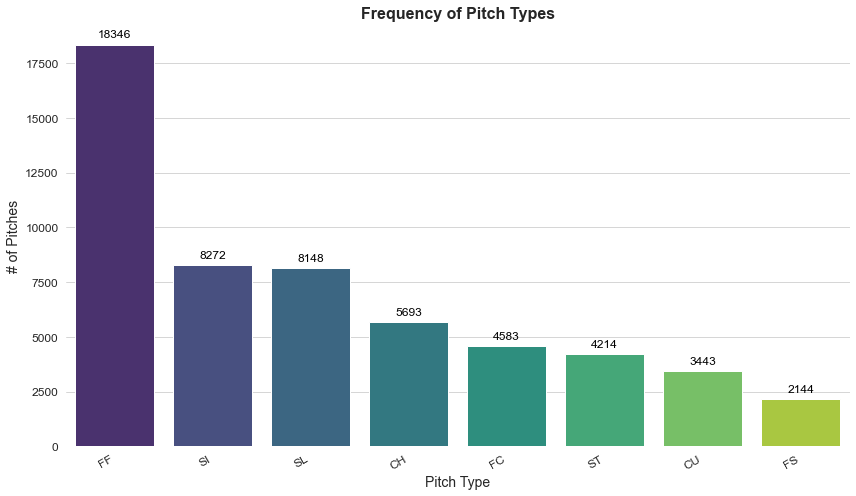

In [8]:
pitch_counts = data.pitch_type.value_counts().nlargest(8).reset_index()
pitch_counts.columns = ['Pitch Type', 'Count']  # Rename columns

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
bar = sns.barplot(
    data=pitch_counts,
    x='Pitch Type',
    y='Count',
    palette='viridis',
    order=pitch_counts.sort_values('Count', ascending=False)['Pitch Type']
)

# Add value labels on bars
for p in bar.patches:
    bar.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom',
                 fontsize=12, color='black', xytext=(0, 5),
                 textcoords='offset points')

# Labels and title
plt.xlabel("Pitch Type", fontsize=14)
plt.ylabel("# of Pitches", fontsize=14)
plt.title("Frequency of Pitch Types", fontsize=16, weight='bold')
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.show()


### Features
We will consider the following factors when classifying pitches.
- **Release Speed** - how fast the pitch is thrown
- **Release Spin Rate** - how fast the pitch spins
- **Pfx_x** - the horizontal movement in feet from the catcher's perspective
- **Pfx_z** - the vertical movement in feet from the catcher's perspective

In [9]:
features = ["release_speed", "release_spin_rate", "pfx_x", "pfx_z"]
data2 = data.dropna(subset = features)
data2 = data2[data2.pitch_type.isin(pitches)]

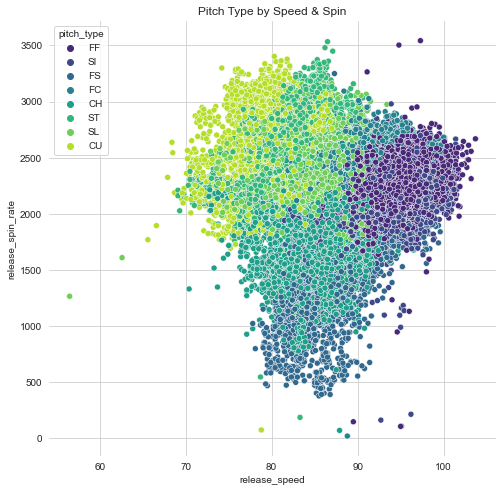

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.despine(fig, left=True, bottom=True)
sns.scatterplot(x="release_speed", y="release_spin_rate",
                hue="pitch_type", 
                palette='viridis', 
                data=data2, ax=ax)
ax.set_title("Pitch Type by Speed & Spin")
plt.show()

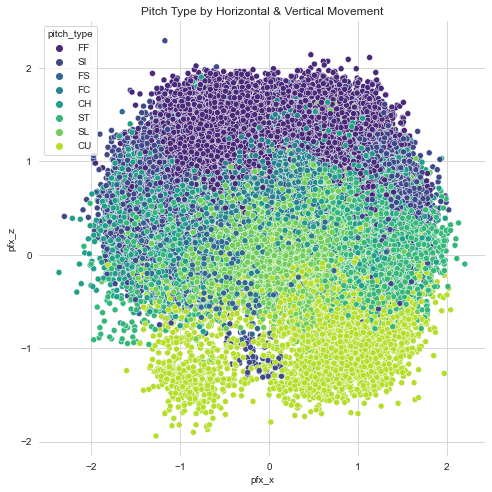

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.despine(fig, left=True, bottom=True)
sns.scatterplot(x="pfx_x", y="pfx_z",
                hue="pitch_type", 
                palette='viridis', 
                data=data2, ax=ax)
ax.set_title("Pitch Type by Horizontal & Vertical Movement")
plt.show()

The two above scatter plots show that the type of pitch does depend on the release speed & spin rate as well as the horizontal and vertical movement. Between these two factors, our decision tree should have plenty to learn from.

In [12]:
# Count pitches by type, balls, and strikes, then pivot for heatmap structure
pivot_data = (
    data2.groupby(["pitch_type", "balls", "strikes"])
        .size()
        .unstack(["balls", "strikes"], fill_value=0)
)

# Get top 3 pitches for each balls-strikes count
df_top_pitches = (
    pivot_data.apply(lambda col: col.nlargest(3).index.tolist())
    .T
    .rename(columns={0: "Pitch 1", 1: "Pitch 2", 2: "Pitch 3"})
)

# Style for Jupyter Notebook
styled_df = (
    df_top_pitches.style
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([
            {"selector": "thead th", "props": [
                ("text-align", "center"),
                ("background-color", "#3498db"),
                ("color", "white"),
                ("font-weight", "bold")
            ]}
        ])
        .set_caption("Top 3 Most Common Pitches by Balls-Strikes Count")
)

styled_df

Another two variables I was initially considering was the number of outs and strikes when a pitch was thrown. this table is cool (which is why I am deciding to keep it), balls and strikes are ultimately not decisive enought for out decision tree

# Decision Trees
Decision Trees are the Machine Learning version of twenty questions. Effectively what our model is going to do is learn from our data and figure out the best questions to ask to classify the data. This is a pre-determined number of yes-no questions (6 in our case) to classify our pitches. The model learns the best questions to ask at each level in order to minimize the entropy in the model. Entropy is how messy each node is. Better explained, high entropy would be if a node consists of many categories and low entropy would be if a node consisted of mostly points from one category. Mathematically,
$$H(Q_m)=\sum_{k\in m} -p_{mk} \log(p_{mk})$$
where $Q_m$ is some node $m$ in our decision tree and $p_{mk}$ is the proportion of pitches labeled $k$ that are present at node $m$. Minimizing entropy ensures that the proportion of one class in a node gets closer to 1 and the proportion for the rest of the classes get closer to 0 -- thus seperating classes to different nodes and allowing for identification. Another measure of impurity is gini which is 
$$H(Q_m)=\sum_{k\in m} p_{mk}(1-p_{mk})$$ 
and measures the proportion of incorrectly classified sets. However, it performs worse in situations like ours where we have vastly different number of each type of clases

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


X = data2[features]
y = data2['pitch_type']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

# Train decision tree
model = DecisionTreeClassifier(max_depth=6, criterion = "entropy")
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

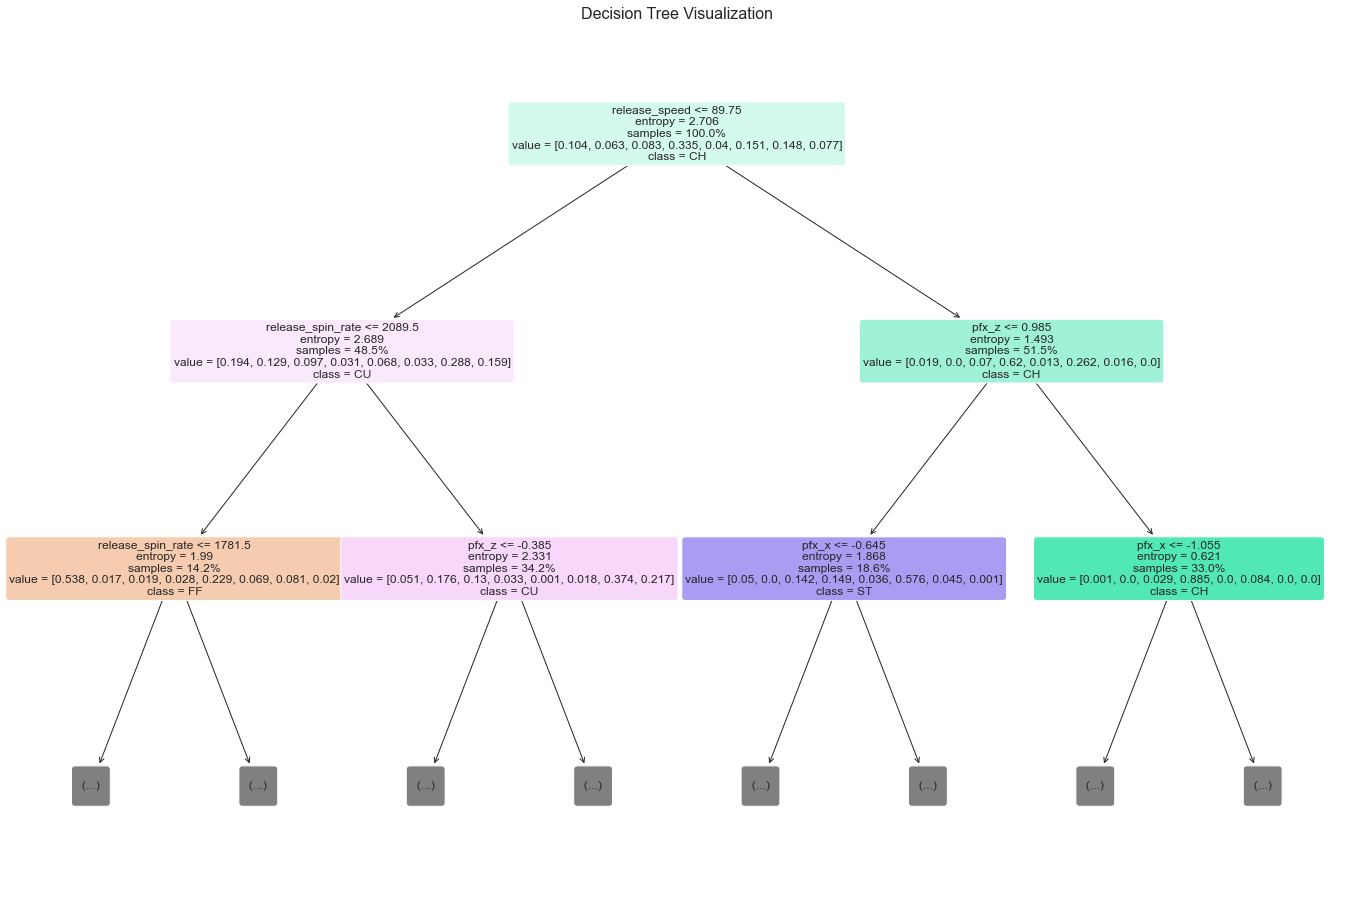

In [14]:
from sklearn.tree import plot_tree

# Set up a larger figure size for clarity
plt.figure(figsize=(24,16))

# Plot the decision tree with enhanced readability
plot_tree(model, 
          feature_names=features, 
          class_names=pitches, 
          rounded=True, 
          filled=True, 
          fontsize=12, 
          proportion=True,
          impurity = True,
         max_depth = 2)  # Show proportion of samples in each node

plt.title("Decision Tree Visualization", fontsize=16)
plt.show()

### Our Tree Visualized
Here we can see the first three questions that our model asks to classify a pitch and its main prediction at each level.

In [18]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

          CH       0.69      0.75      0.72      1136
          CU       0.90      0.78      0.83       699
          FC       0.59      0.61      0.60       937
          FF       0.90      0.87      0.88      3644
          FS       0.60      0.52      0.56       401
          SI       0.76      0.80      0.78      1661
          SL       0.76      0.70      0.73      1651
          ST       0.67      0.81      0.74       828

    accuracy                           0.78     10957
   macro avg       0.73      0.73      0.73     10957
weighted avg       0.78      0.78      0.78     10957



Our classification of pitches has a 758 accuracy, indicating that it is fairly reliable. 
* The two fastball variants FF (Four-Seam Fastball) and SI (Sinker) showed high precision and recall, which reflects their distinct characteristics and high prevelance.
* However, FC (Cutter) and FS (Splitter) had lower recall, meaning the model difficulty in consistently identifying them. This could be due to their lower prevelance in the dataset. 
* The CU (Curveball) demonstrated high precision but relatively lower recall, so when classified, it was usually correct, but some curveballs might have been misclassified. 
* The ST (Sweeper) has a higher recall than precision meaning that it correctly identifies most sweepers but also has a lot of false positiives.
* The CH (Change Up) and SL (slider) both had about 70% precision and recall. Thus they classify most balls but with some amount of false positives.



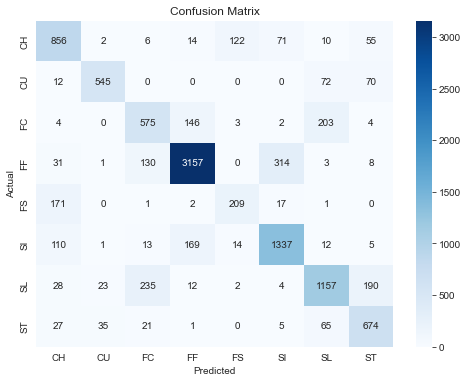

In [19]:
from sklearn.metrics import confusion_matrix
labels = ["CH", "CU", "FC", "FF", "FS", "SI", "SL", "ST"]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Looking at our confusion matrix, we can see the following misclassifactions:
* FF predicted as SI -- these two pitches make sense as they are both fast balls.
* FC predicted as FF and SL -- this makes sense as a cutter is a mix of a slider and fast ball
* CH predicted as FS

From these results, we can consider other factors like where the pich is released, where it ends up relative to the plate, and also creating some factor for pitcher tendencies. Despite some missclassifications, our decision tree is still very accuruate. We will see just how accurate we can get given a few more factors and a more robust model consisting of many decision trees: a random forest.